In [56]:
import pandas as pd 
import numpy as np
import math

tmp = pd.read_csv('Weed_Resistance_Data.csv', sep = ',', header=None)
params_in = list(tmp[:21][0])


params_in = np.array(params_in)

In [57]:
class General:
    def __init__(self,params_in):
        self.nsim = params_in[0]             #number of simulations
        self.nYears = params_in[1]               #number of years
        self.nCohorts = params_in[2]             #number of cohorts
        self.nLoci = params_in[3]                            #number of gene loci
        self.nGeno = math.pow(3,self.nLoci)             #number of genotypes
        self.fieldSize = params_in[4]           #field size
        self.selfingCoeff = params_in[5]         #selfing coefficient 
        self.seedDelay = params_in[6]          #seed delay
        self.femaleFrac = params_in[7]
        self.f_RO = params_in[18]          #latent time
        self.f_CR = params_in[19]     #critical response
        self.f_TR = params_in[20]
        self.currentYear = 1
        self.currentCohort = 1
        self.TillingFreq = np.loadtxt('Corteva/BMP_Matlab_Code/Tilling_Data.txt')
class Upper:
    pass
class Lower:
    pass

class Init:
    def __init__(self, params_in):
        self.Upper = Upper
        self.Lower = Lower
        self.Upper.seedDensity = params_in[8]      #initial upper bank density
        self.Lower.seedDensity = params_in[9]       #initial lower bank density
        self.Upper.ResAlleleFreq = params_in[10:17:2]   #initial upper resistant allele frequency
        self.Lower.ResAlleleFreq = params_in[11:18:2] 
class Germination:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.survivalFraction = self.survivalfrac()


    def survivalfrac(self):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,0]
                if row < 49:
                    row += 1

        return survivalFraction
        
# ger = Germination(tmp)
class Cultivation:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.survivalFraction = self.survivalfrac()


    def survivalfrac(self):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,1]
                if row < 49:
                    row += 1

        return survivalFraction
class Hand:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.survivalFraction = self.survivalfrac()


    def survivalfrac(self):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,2]
                if row < 49:
                    row += 1

        return survivalFraction
class Mature:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.maxplants = self.max_crop(3)
        self.cropParam = self.max_crop(4)
        self.weedCompetition = self.max_crop(5)

    def max_crop(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction
class SeedProd:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.maxyield = self.max_crop(6)
        self.cropParam = self.max_crop(7)
        self.weedCompetition = self.max_crop(8)

    def max_crop(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction
class Mutation:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])

        self.muR2S_locus1 = self.mut(9)
        self.muS2R_locus1 = self.mut(10)
        self.muR2S_locus2 = self.mut(11)
        self.muS2R_locus2 = self.mut(12)
        self.muR2S_locus3 = self.mut(13)
        self.muS2R_locus3 = self.mut(14)
        self.muR2S_locus4 = self.mut(15)
        self.muS2R_locus4 = self.mut(16)

    def mut(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction
class Predation:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.survivalFraction = self.survivalfrac(17)


    def survivalfrac(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction
class Winter:
    def __init__(self, tmp):
        self.general = General(params_in)
        self.data = np.array(tmp[20:])
        self.uppersurvivalFraction = self.survivalfrac(18)
        self.lowersurvivalFraction = self.survivalfrac(19)


    def survivalfrac(self,column):
        row = 0
        survivalFraction = np.zeros((int(self.general.nYears),int(self.general.nCohorts)))
        for i in range(int(self.general.nYears)):
            for j in range(int(self.general.nCohorts)):
                survivalFraction[i][j] = self.data[row,column]
                if row < 49:
                    row += 1

        return survivalFraction
class Herbicide1:
    def __init__(self, Herbicide_data):
        self.general = General(params_in)
        self.data = Herbicide_data
        self.targetLocus = 1
        self.efficacy_SS = np.zeros((25,2))

        self.efficacy_SS[0:25,0] = Herbicide_data[0:25,1]
        self.efficacy_SS[0:25,1] = Herbicide_data[25:50,1]

        self.efficacy_RS = np.zeros((25,2))

        self.efficacy_RS[0:25,0] = Herbicide_data[0:25,2]
        self.efficacy_RS[0:25,1] = Herbicide_data[25:50,2]

        self.efficacy_RR = np.zeros((25,2))

        self.efficacy_RR[0:25,0] = Herbicide_data[0:25,3]
        self.efficacy_RR[0:25,1] = Herbicide_data[25:50,3]
class Herbicide2:
    def __init__(self, Herbicide_data):
        self.general = General(params_in)
        self.data = Herbicide_data
        self.targetLocus = 2
        self.efficacy_SS = np.zeros((25,2))

        self.efficacy_SS[0:25,0] = Herbicide_data[50:75,1]
        self.efficacy_SS[0:25,1] = Herbicide_data[75:100,1]

        self.efficacy_RS = np.zeros((25,2))

        self.efficacy_RS[0:25,0] = Herbicide_data[50:75,2]
        self.efficacy_RS[0:25,1] = Herbicide_data[75:100,2]

        self.efficacy_RR = np.zeros((25,2))

        self.efficacy_RR[0:25,0] = Herbicide_data[50:75,3]
        self.efficacy_RR[0:25,1] = Herbicide_data[75:100,3]
class Herbicide3:
    def __init__(self, Herbicide_data):
        self.general = General(params_in)
        self.data = Herbicide_data
        self.targetLocus = 3
        self.efficacy_SS = np.zeros((25,2))

        self.efficacy_SS[0:25,0] = Herbicide_data[100:125,1]
        self.efficacy_SS[0:25,1] = Herbicide_data[125:150,1]

        self.efficacy_RS = np.zeros((25,2))

        self.efficacy_RS[0:25,0] = Herbicide_data[100:125,2]
        self.efficacy_RS[0:25,1] = Herbicide_data[125:150,2]

        self.efficacy_RR = np.zeros((25,2))

        self.efficacy_RR[0:25,0] = Herbicide_data[100:125,3]
        self.efficacy_RR[0:25,1] = Herbicide_data[125:150,3]
class Herbicide4:
    def __init__(self, Herbicide_data):
        self.general = General(params_in)
        self.data = Herbicide_data
        self.targetLocus = 4
        self.efficacy_SS = np.zeros((25,2))

        self.efficacy_SS[0:25,0] = Herbicide_data[150:175,1]
        self.efficacy_SS[0:25,1] = Herbicide_data[175:200,1]

        self.efficacy_RS = np.zeros((25,2))

        self.efficacy_RS[0:25,0] = Herbicide_data[150:175,2]
        self.efficacy_RS[0:25,1] = Herbicide_data[175:200,2]

        self.efficacy_RR = np.zeros((25,2))

        self.efficacy_RR[0:25,0] = Herbicide_data[150:175,3]
        self.efficacy_RR[0:25,1] = Herbicide_data[175:200,3]
class P:
    def __init__(self,params_in, Herbicide_data,tmp):
        self.General = General(params_in)
        self.Init = Init(params_in)
        self.Germination = Germination(tmp)
        self.Cultivation = Cultivation(tmp)
        self.Hand = Hand(tmp)
        self.Mature = Mature(tmp)
        self.SeedProd = SeedProd(tmp)
        self.Mutation = Mutation(tmp)
        self.Predation = Predation(tmp)
        self.Winter = Winter(tmp)
        self.Herbicide1 = Herbicide1(Herbicide_data)
        self.Herbicide2 = Herbicide2(Herbicide_data)
        self.Herbicide3 = Herbicide3(Herbicide_data)
        self.Herbicide4 = Herbicide4(Herbicide_data)

     
        
    def generate_key(self):
        key = np.zeros((self.nLoci,self.nGeno))
        tmp = np.zeros((self.nLoci,1))
        for k in range(int(self.nGeno)):
            key[:,k] = tmp.reshape((4,))
            tmp = self.odometer(tmp,2)
        key_text = 0
        key_text = []
        for k in range(int(self.nGeno)):
            tmp = ''
            for j in range(int(self.nLoci)):
                locus_string = str(j+1)
                if key[j,k] == 0:
                    tmp = tmp + 'S' + locus_string + 'S' + locus_string
                elif key[j,k] == 1:
                    tmp = tmp + 'R' + locus_string + 'S' + locus_string
                else:
                    tmp = tmp + 'R' + locus_string + 'R' + locus_string
            key_text.append(tmp)
        # print('key text', key_text)
        return key, key_text
    
    def odometer(self,odo,base_num):
        Ndigits = len(odo)
        j = 0
        while j < Ndigits:
            if odo[j] < base_num:
                odo[j] = odo[j] +1
                break
            odo[j] = 0
            j = j+1
        return odo

    def matingEquilibrium(self,p1,key):
        q = 1 - p1
        populationFraction_outCross = np.ones((1,int(self.nGeno)))

        for j in range(int(self.nLoci)):
            for k in range((self.nGeno)):
                if key[j,k] == 2:
                    populationFraction_outCross[0][k] = populationFraction_outCross[0][k] *(math.pow(p1[j],2))
                elif key[j,k] == 1:
                    populationFraction_outCross[0][k] = populationFraction_outCross[0][k] *2*p1[j]*q[j]
                else:
                    populationFraction_outCross[0][k] = populationFraction_outCross[0][k] *(math.pow(q[j],2))

        return populationFraction_outCross[0]
def deepTill(upperbank,lowerbank,tillFrequency,currentYear):
    if tillFrequency[currentYear] ==1:
        tmp = upperbank
        upperbank = lowerbank
        lowerbank = tmp 
    else:
        pass
    return upperbank, lowerbank

def seedImmigration(nGeno):
    seedIN = np.zeros(int(nGeno))
    return seedIN

def extinction(oldPopulation,fieldSize):
    # print("shape of oldpop from extinction: ", oldPopulation.shape)


    if fieldSize == math.inf:
        newPopulation = oldPopulation
    elif fieldSize == 0:
        newPopulation = oldPopulation
    else:
        nGeno = int(len(oldPopulation))
        rndExtinct = np.random.rand(nGeno)
        newPopulation = np.zeros(nGeno)

        for i in range(nGeno):
            if oldPopulation[i] == 0:
                newPopulation[i] =0
            elif oldPopulation[i] >= 1/fieldSize:
                newPopulation[i] = oldPopulation[i]
            elif rndExtinct[i] > 0.5:
                newPopulation[i] = 1/fieldSize
            else:
                newPopulation[i] = 0

    return newPopulation

def survival(oldPopulation,fSurvival):

    newPopulation = fSurvival*oldPopulation


    return newPopulation

def selectiveSurvival(oldPop,fSurvival,targetLocus,key):
    nLoci, nGeno = key.shape
    newPop = oldPop*0
    if targetLocus > nLoci:
        newPop = oldPop
    else:
        for i in range(int(nGeno)):
            if key[targetLocus-1][i] == 0:
                newPop[i] = fSurvival[0]*oldPop[i]
            elif key[targetLocus-1][i] == 1:
                newPop[i] = fSurvival[1]*oldPop[i]
            else: 
                newPop[i] = fSurvival[2]*oldPop[i]
    return newPop

def competition(oldPop,A,B,C):
    # print("type of oldpop: ", type(oldPop))

    if isinstance(oldPop, np.ndarray):
        # print("its a list")
        totalPop = float(np.sum(oldPop))
        
        a = [A*i for i in list(oldPop)]
        b = (1+B+C*totalPop)


        newPop = [i/b for i in a] 


    elif isinstance(oldPop,float):
        
        totalPop = oldPop
        a = A*oldPop
        b = (1+B+C*totalPop)
        

        newPop = a/b

    else:
        pass
        # print("confusionnnn") 

    # print(" newpop: ", newPop)

    return newPop


def mating(population,s,key):

    nLoci,nGeno = key.shape
    if sum(population) == 0:
        newFracOut = np.zeros(len(population))
    else:
        newFracOut = np.ones(nGeno)
        p = np.zeros(nLoci)

        for j in range(int(nLoci)):
            for k in range(int(nGeno)):
                if key[j][k] == 2:
                    p[j] = p[j] + 2*population[k]
                elif key[j,k] == 1:
                    p[j] = p[j] + population[k]

        p = .5*p/sum(population)
        q = 1 -p

        for j in range(int(nLoci)):
            for k in range(int(nGeno)):
                if key[j][k] == 2:
                    newFracOut[k] = newFracOut[k]*(math.pow(p[j],2))
                elif key[j,k] == 1:
                    newFracOut[k] = newFracOut[k]*2*p[j]*q[j]
                else:
                    newFracOut[k] = newFracOut[k]*(math.pow(q[j],2))


    name = 'selfTable'+str(nLoci)+'.txt'
    name = './Corteva/BMP_Matlab_Code/' + name
    selfingTable = np.array(pd.read_csv(name, sep=',', header=None))
    newFracself = np.matmul(population,selfingTable)
    s = Params.General.selfingCoeff
    newFrac = s*newFracself + (1-s)*newFracOut

    return newFrac

def mutation(population,muS2R,muR2S,targetLocus,key):
    mu = muR2S
    nu = muS2R

    mutatedPopulation = population[0]

    for j in range(key.shape[1]):
        tmp = (j%math.pow(3,(targetLocus-1)))+1
        indSS = int(tmp-1)
        indRS = int(indSS + math.pow(3,(targetLocus-1)))
        indRR = int(indRS + math.pow(3,(targetLocus-1)))

        if key[targetLocus-1,j] == 2:
            mutatedPopulation[indRR] = mutatedPopulation[indRR] - 2*mu*population[indRR] + (mu**2)*population[indRR]
            mutatedPopulation[indRS] = mutatedPopulation[indRS] + 2*mu*population[indRR] - 2*(mu**2)*population[indRR]
            mutatedPopulation[indSS] = mutatedPopulation[indSS] + (mu**2)*population[indRR]
        elif key[targetLocus-1,j] == 1:
            mutatedPopulation[indRR] = mutatedPopulation[indRR] + nu*population[indRS] 
            mutatedPopulation[indRS] = mutatedPopulation[indRS] + nu*population[indRS] - mu*population[indRS]
            mutatedPopulation[indSS] = mutatedPopulation[indSS] + mu*population[indRS]    

        else:
            mutatedPopulation[indRR] = mutatedPopulation[indRR] + math.pow(nu,2)*population[indSS] 
            mutatedPopulation[indRS] = mutatedPopulation[indRS] + 2*nu*population[indSS] - 2*(math.pow(nu,2))*population[indSS]
            mutatedPopulation[indSS] = mutatedPopulation[indSS] - 2*nu*population[indSS] + (math.pow(nu,2))*population[indSS]
        population = mutatedPopulation

    return mutatedPopulation

In [58]:
General_TillingFrequency = np.loadtxt('Corteva/BMP_Matlab_Code/Tilling_Data.txt')
Herbicide_data = np.loadtxt('Corteva/BMP_Matlab_Code/Herbicide_Data.txt')

In [59]:
class PrepareParams(P):
    def __init__(self):
        self.General = General(params_in)
        self.Init = Init(params_in)
        self.Germination = Germination(tmp)
        self.Cultivation = Cultivation(tmp)
        self.Hand = Hand(tmp)
        self.Mature = Mature(tmp)
        self.SeedProd = SeedProd(tmp)
        self.Mutation = Mutation(tmp)
        self.Predation = Predation(tmp)
        self.Winter = Winter(tmp)
        self.Herbicide1 = Herbicide1(Herbicide_data)
        self.Herbicide2 = Herbicide2(Herbicide_data)
        self.Herbicide3 = Herbicide3(Herbicide_data)
        self.Herbicide4 = Herbicide4(Herbicide_data)
        self.nLoci = int(self.General.nLoci)
        self.nGeno = int(self.General.nGeno)
        self.key, self.key_text = self.generate_key()
        self.General.UpperSeedBank = self.matingEquilibrium(self.Init.Upper.ResAlleleFreq,self.key)*self.Init.Upper.seedDensity
        self.General.LowerSeedBank = self.matingEquilibrium(self.Init.Lower.ResAlleleFreq,self.key)*self.Init.Lower.seedDensity     

In [60]:
par = P(params_in,Herbicide_data,tmp)

In [61]:
class Population:
    pass
Params = PrepareParams()
nCohorts = int(Params.General.nCohorts)      
nYears = int(Params.General.nYears)        
nLoci = int(Params.General.nLoci)               
nGeno = int(Params.General.nGeno)              
fieldSize = int(Params.General.fieldSize)     


Population.seedBank = np.zeros((nYears,nGeno,nCohorts))


Population.lowerBank = np.zeros((nYears,nGeno))


Population.immSeed = np.zeros((nYears,nGeno,nCohorts))


Population.emSeed = np.zeros((nYears,nGeno,nCohorts))

Population.germination = np.zeros((nYears,nGeno,nCohorts))


Population.ungerminated = np.zeros((nYears,nGeno,nCohorts))


Population.herbicide1 = np.zeros((nYears,nGeno,nCohorts))
Population.herbicide2 = np.zeros((nYears,nGeno,nCohorts))
Population.herbicide3 = np.zeros((nYears,nGeno,nCohorts))
Population.herbicide4 = np.zeros((nYears,nGeno,nCohorts))
Population.seedProd = np.zeros((nYears,nGeno,nCohorts))

Population.mature = np.zeros((nYears,nGeno,nCohorts))


Population.hand = np.zeros((nYears,nGeno,nCohorts))


Population.immPol = np.zeros((nYears,nGeno,nCohorts))


Population.emPol = np.zeros((nYears,nGeno,nCohorts))


Population.newSeed = np.zeros((nYears,nGeno,nCohorts))


Population.mutated = np.zeros((nYears,nGeno,nCohorts))


Population.predation = np.zeros((nYears,nGeno,nCohorts))


Population.winter = np.zeros((nYears,nGeno))


Population.Res = np.zeros((1, 3))


Population.seedBank[0,:,0] = Params.General.UpperSeedBank
Population.lowerBank[0,:] = Params.General.LowerSeedBank

In [62]:
nYears = int(Params.General.nYears)
nCohorts = int(Params.General.nCohorts)

nYears = 25
nCohorts = 2

def variable(y,c,a):
    printe = " year : "+ str(y)+" cohort : "+str(c)+" round : "+str(a)
    print(printe)

a  = 0
var_print = np.zeros((50,81))


for y in range(nYears):
    tempSeedBank = np.zeros(81)
    # Population.seedBank[y,:,1],Population.lowerBank[y,:] = deepTill(Population.seedBank[y,:,1],
    #                                                             Population.lowerBank[y,:],
    #                                                             Params.General.TillingFreq,y)
    
    
    for c in range(nCohorts):
        
        ImmSeed = seedImmigration(nGeno)
        seedBank = Population.seedBank[y,:,c]+ ImmSeed
        seedBank = extinction(seedBank,fieldSize)
        fGerm = Params.Germination.survivalFraction[y,c]
        germination = survival(seedBank,fGerm)
        ungerminated = seedBank - germination
        germination = extinction(germination,fieldSize)
        fCult = Params.Cultivation.survivalFraction[y,c]
        cult = survival(germination,fCult)
        cult = extinction(cult,fieldSize)

        fSS = 1 - Params.Herbicide1.efficacy_SS[y,c]
        fRS = 1 - Params.Herbicide1.efficacy_RS[y,c]
        fRR = 1 - Params.Herbicide1.efficacy_RR[y,c]

        targetLocus = Params.Herbicide1.targetLocus

        herbicide1_ = selectiveSurvival(cult,[fSS,fRS,fRR],targetLocus,Params.key)

        herbicide1 = extinction(herbicide1_,fieldSize)

        fSS = 1 - Params.Herbicide2.efficacy_SS[y,c]
        fRS = 1 - Params.Herbicide2.efficacy_RS[y,c]
        fRR = 1 - Params.Herbicide2.efficacy_RR[y,c]

        targetLocus = Params.Herbicide2.targetLocus

        herbicide2_ = selectiveSurvival(herbicide1,[fSS,fRS,fRR],targetLocus,Params.key)
                
        herbicide2 = extinction(herbicide2_,fieldSize)

        fSS = 1 - Params.Herbicide3.efficacy_SS[y,c]
        fRS = 1 - Params.Herbicide3.efficacy_RS[y,c]
        fRR = 1 - Params.Herbicide3.efficacy_RR[y,c]

        targetLocus = Params.Herbicide3.targetLocus

        herbicide3_ = selectiveSurvival(herbicide2,[fSS,fRS,fRR],targetLocus,Params.key)
        herbicide3 = extinction(herbicide3_,fieldSize)

        fSS = 1 - Params.Herbicide4.efficacy_SS[y,c]
        fRS = 1 - Params.Herbicide4.efficacy_RS[y,c]
        fRR = 1 - Params.Herbicide4.efficacy_RR[y,c]

        targetLocus = Params.Herbicide4.targetLocus

        herbicide4_ = selectiveSurvival(herbicide3,[fSS,fRS,fRR],targetLocus,Params.key)
        herbicide4 = extinction(herbicide4_,fieldSize)

        A = Params.Mature.maxplants[y,c]
        B = Params.Mature.cropParam[y,c]
        C = Params.Mature.weedCompetition[y,c]

        mature_ = competition(herbicide4,A,B,C)
        mature = extinction(mature_,fieldSize)
        fHand = Params.Hand.survivalFraction[y,c]

        hand = survival(mature,fHand)
        hand = extinction(hand,fieldSize)
        
        A = Params.SeedProd.maxyield[y,c]
        B = Params.SeedProd.cropParam[y,c]
        C = Params.SeedProd.weedCompetition[y,c]
        sum_hand = float(np.sum(hand))
        seedYield = competition(sum_hand,A,B,C)
        newFrac = mating(hand,Params.General.selfingCoeff, Params.key)
        seedProd_= newFrac*seedYield*Params.General.femaleFrac
        seedProd = extinction(seedProd_,fieldSize)

        targetLocus = 1
        muS2R = Params.Mutation.muS2R_locus1[y,c]
        muR2S = Params.Mutation.muR2S_locus1[y,c]
       
        if muS2R==0 and muR2S==0:
            mutated_locus1 = seedProd
        else:
            mutated_locus1 = mutation(seedProd,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus1 = extinction(mutated_locus1,fieldSize)

        targetLocus = 2
        muS2R = Params.Mutation.muS2R_locus2[y,c]
        muR2S = Params.Mutation.muR2S_locus2[y,c]

        if muS2R==0 and muR2S==0:
            mutated_locus2 = mutated_locus1
        else:
            mutated_locus2 = mutation(mutated_locus1,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus2 = extinction(mutated_locus2,fieldSize)

        targetLocus = 3
        muS2R = Params.Mutation.muS2R_locus3[y,c]
        muR2S = Params.Mutation.muR2S_locus3[y,c]

        if muS2R==0 and muR2S==0:
            mutated_locus3 = mutated_locus2
        else:
            mutated_locus3 = mutation(mutated_locus2,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus3 = extinction(mutated_locus3,fieldSize)

        targetLocus = 4
        muS2R = Params.Mutation.muS2R_locus4[y,c]
        muR2S = Params.Mutation.muR2S_locus4[y,c]

        if muS2R==0 and muR2S==0:
            mutated_locus4 = mutated_locus3
        else:
            mutated_locus4 = mutation(mutated_locus3,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus4 = extinction(mutated_locus4,fieldSize)

        fPred = Params.Predation.survivalFraction[y,c]
        predation = survival(mutated_locus4,fPred)
        predation = extinction(predation,fieldSize)


        # print(predation) 
        if Params.General.seedDelay == 0:
            if c < nCohorts-1:
                print("1-1 correct")
                Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + predation + ungerminated
            else:
                print("1-2 correct")
                tempSeedBank = tempSeedBank + ungerminated + predation
        else:
            tempSeedBank = tempSeedBank + predation
            if c < nCohorts:
                print("2-1 correct")
                Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + ungerminated
            else:
                print("2-2 correct")
                tempSeedBank = tempSeedBank + ungerminated
        variable(y,c,a)
        a += 1

    if y != nYears-1:
        fWint_upper = Params.Winter.uppersurvivalFraction[y][c]
        fWint_lower = Params.Winter.lowersurvivalFraction[y][c]



        winter_ = survival(tempSeedBank,fWint_upper)
        winter = extinction(winter_,fieldSize)

        Population.winter[y,:] = winter
        Population.seedBank[y+1,:,0] = Population.seedBank[y+1,:,0] + winter
        Population.lowerBank[y+1,:] = survival(Population.lowerBank[y,:],fWint_lower)
        Population.lowerBank[y+1,:] = extinction(Population.lowerBank[y+1,:],fieldSize)

    else:
        print('broken at 50')
        break
    



1-1 correct
 year : 0 cohort : 0 round : 0
1-2 correct
 year : 0 cohort : 1 round : 1
1-1 correct
 year : 1 cohort : 0 round : 2
1-2 correct
 year : 1 cohort : 1 round : 3
1-1 correct
 year : 2 cohort : 0 round : 4
1-2 correct
 year : 2 cohort : 1 round : 5
1-1 correct
 year : 3 cohort : 0 round : 6
1-2 correct
 year : 3 cohort : 1 round : 7
1-1 correct
 year : 4 cohort : 0 round : 8
1-2 correct
 year : 4 cohort : 1 round : 9
1-1 correct
 year : 5 cohort : 0 round : 10
1-2 correct
 year : 5 cohort : 1 round : 11
1-1 correct
 year : 6 cohort : 0 round : 12
1-2 correct
 year : 6 cohort : 1 round : 13
1-1 correct
 year : 7 cohort : 0 round : 14
1-2 correct
 year : 7 cohort : 1 round : 15
1-1 correct
 year : 8 cohort : 0 round : 16
1-2 correct
 year : 8 cohort : 1 round : 17
1-1 correct
 year : 9 cohort : 0 round : 18
1-2 correct
 year : 9 cohort : 1 round : 19
1-1 correct
 year : 10 cohort : 0 round : 20
1-2 correct
 year : 10 cohort : 1 round : 21
1-1 correct
 year : 11 cohort : 0 round 

In [63]:
pd.DataFrame(Population.seedBank[:3,:3,1])

,0,1,2
0,47.901818,0.313382,0.000523
1,79475.002891,73392.206077,17208.613493
2,263495.316950,850190.955131,834736.090700


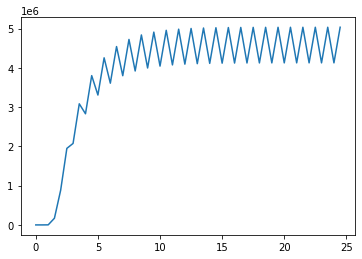

In [64]:
# nYears,nGeno,nCohorts = Population.seedBank.shape
N = nYears*nCohorts

newPop = np.zeros((N,nGeno))

k = 0
for y in range(nYears):
    for c in range(nCohorts):
        newPop[k,:] = Population.seedBank[y,:,c]
        k = k + 1

import matplotlib.pyplot as plt 
time = np.arange(0,N)/nCohorts
pltPop = np.sum(newPop, axis=1)

plt.plot(time,pltPop)

In [ ]:
#         Population.immSeed[y,:,c] = ImmSeed
#         Population.ungerminated[y,:,c] = ungerminated
#         Population.germination[y,:,c] = germination
#         Population.herbicide1[y,:,c] = herbicide1
#         Population.herbicide2[y,:,c] = herbicide2
#         Population.herbicide3[y,:,c] = herbicide3
#         Population.herbicide4[y,:,c] = herbicide4
#         Population.mature[y,:,c] = mature
#         Population.hand[y,:,c] = hand
#         Population.seedProd[y,:,c] = seedProd
#         Population.predation[y,:,c] = predation